## Conditional Edge를 활용한 Agentic-RAG

### Conditional Edge 
- `conditional_edge는` `LangGraph`에서 조건부 실행 흐름을 제어하는 특별한 종류의 엣지
- 일반 `edge`와 달리, 특정 조건이 충족될 때만 해당 경로로 실행이 진행됩니다.

### 노드 (Node) vs 조건부 엣지 함수 (Conditional Edge Function)
-  노드 (Node)
    - State를 받아서 "State"를 업데이트하고 반환
    - 실제 작업을 수행 (데이터 검색, 생성, 변환 등)
    - 그래프에 add_node()로 등록 필요
- 조건부 엣지 함수 (Conditional Edge Function)
    - State를 받아서 "다음 노드 이름"을 반환
    - 실제 작업을 수행하지 않고, 라우팅만 결정
    - 그래프에 노드로 등록하면 안 됨! add_conditional_edges()의 인자로 바로 전달

### `add_edge` vs `add_conditional_edge`
- add_edge("출발노드_이름": "도착노드_이름")
    - Node → Node 직접 연결
    - 항상 같은 경로
    - 예: graph_builder.add_edge("rewrite", "retrieve")

- add_conditional_edges("출발노드_이름", 조건_판단_함수)
    - 출발 노드: 실제 작업을 수행하는 노드
    - 조건 판단 함수: 다음 노드를 결정하는 라우터
    - 도착 노드들: 함수가 반환하는 문자열에 해당하는 노드들 (자동으로 매핑됨)
    - 예: graph_builder.add_conditional_edges("retrieve", check_doc_relevance)

### 그래프 흐름
```
[Node: retrieve] 
    ↓ (State 업데이트: context 추가)
    
[Function: check_doc_relevance]  
    ↓ (State는 그대로, 라우팅만 결정)
    
  조건 판단
      ↓
┌─────┴─────┐
↓           ↓
[Node:     [Node:
generate]  rewrite]
```

In [50]:
from dotenv import load_dotenv

load_dotenv()

True

In [51]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

# 기존에 생성한 vector store 불러오기 
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'income_tax_collection',
    persist_directory = '../income_tax_collection' #로컬에 영구 저장 버전 
)

In [52]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [53]:
# State 정의 
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [54]:
# Node 정의
from langchain_core.prompts import ChatPromptTemplate

# 사용자 query로 vector store에서 검색을 수행하는 노드 
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    
    docs = retriever.invoke(query)

    return {'context': docs}

In [55]:
from langchain_openai import ChatOpenAI
from langsmith import Client

llm = ChatOpenAI(model='gpt-4o')
client = Client()

In [56]:
# context와 query를 받아서 LLM 답변을 생성하는 노드 
def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    
    prompt = client.pull_prompt("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response.content}

In [57]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 검색 결과의 정확도를 높이도록 사용자 쿼리를 변환하는 노드 
def rewrite(state: AgentState) -> AgentState:
    query = state['query']
    dictionary = ["사람을 나타내는 표현 -> 거주자"]

    keyword_dictionary_prompt = ChatPromptTemplate.from_template(
        f"""사용자의 질문을 보고, 키워드 사전을 참고해서 사용자의 질문을 변경해주세요. 
        사전: {dictionary}
        사용자의 질문: {{question}}
        """
    )
    keyword_dictionary_chain = keyword_dictionary_prompt| llm | StrOutputParser()
    rewritten_query = keyword_dictionary_chain.invoke({'question': query})

    return {'query': rewritten_query}

In [ ]:
from typing import Literal

# retriver에서 검색한 문서의 관련성을 판단하는 라우팅 함수 
def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query'] 
    context = state['context'] 

    doc_relevance_prompt = client.pull_prompt("rlm/rag-document-relevance")

    doc_relevance_chain = doc_relevance_prompt | llm

    response = doc_relevance_chain.invoke({
        "input": {
            "question": query,
            "documents": context
        }
    })
    # doc_relevance_chain의 결과: 문서 관련성이 높으면 1, 아니면 0 
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

In [59]:
from langgraph.graph import StateGraph, START, END

#  그래프 빌더 생성 
graph_builder = StateGraph(AgentState)

# 노드 추가 
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)


In [60]:

# 엣지 추가 
graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges("retrieve", c)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [61]:
# 그래프 생성 
graph = graph_builder.compile() 

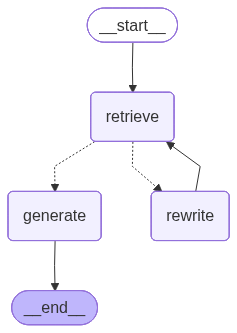

In [62]:
# 그래프 시각화 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
# 그래프 실행 
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

{'query': '거주자 연봉 5천만원 세금',
 'context': [Document(id='587bb229-bf18-4b44-b8e0-5225e00aeaad', metadata={'source': '../documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='7b33c9ac-2ce1-4711-bcc5-566f0486a63d', metadata={'source': '../documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2